In [47]:
# importing libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

import numpy as np
from matplotlib import pyplot as plt

import datetime

fin = open("/media/data/slavadoData/creds_mysql.txt", 'r')
creds = fin.read().split("\n")

In [48]:
import mysql.connector

mydb = mysql.connector.connect(
  host= creds[0],
  user= creds[1],
  passwd= creds[2]
)

print(mydb)

In [49]:
# Read sea conditions data from database
query = "select * from d4c2020.meteo"

df_meteo = pd.read_sql(query, mydb)
df_meteo.head()

,market,year,month,day,runtime,swh,sst,mwd,mwp,wind,dwi
0,Albufeira,2016,1,1,0,1.55,17.62,282.84,11.97,4.54,143.10
1,Albufeira,2016,1,1,6,1.50,17.60,280.61,11.43,5.55,224.17
2,Albufeira,2016,1,1,12,1.72,17.47,263.51,8.61,9.44,229.21
3,Albufeira,2016,1,1,18,2.02,17.47,256.31,7.45,10.08,250.84
4,Albufeira,2016,1,2,0,1.79,17.47,269.48,9.51,3.46,318.72


In [50]:
# Check if all years have all observations
pd.crosstab(df_meteo[df_meteo['market']=='Costa Caparica']['year'], df_meteo[df_meteo['market']=='Costa Caparica']['month'])

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
18,0,0,0,0,0,0,0,0,0,1,0,0
2016,124,116,132,120,127,120,127,124,120,128,119,128
2017,124,112,136,120,128,120,128,123,120,128,120,128
2018,124,112,136,119,128,120,128,124,120,127,120,128
2019,121,112,136,120,128,119,128,124,120,128,120,128
2020,124,115,132,119,128,120,128,124,120,128,120,128


In [51]:
# Calculate date and week 
df_meteo['date'] = df_meteo['year'].astype(str) + '-' + df_meteo['month'].astype(str).str.pad(2, side='left', fillchar='0') +  '-' + df_meteo['day'].astype(str).str.pad(2, side='left', fillchar='0')
df_meteo['week'] = pd.DatetimeIndex(df_meteo['date']).week


In [52]:
# Generate year_week variable

# We want to aggregate data per year-week; however, the last days of an year may be attributed to week 1
# of the next year. Simply concatenating year-week would produce a wrong value.
# We calculate a new year to concatenate, correcting this issue.

def year4week(row):
    if (row['week'] == 1) and (row['month'] == 12):
        return row['year'] + 1
    else:
        return row['year']
    
df_meteo['year4week'] = df_meteo.apply(year4week, axis=1)

def year_correct(row):
    if (row['week'] == 1) and (row['month'] == 12):
        return row['year'] + 1
    else:
        return row['year']
    
    
df_meteo['year_corrected'] = df_meteo.apply(year_correct, axis=1)

df_meteo['year_week'] = df_meteo['year_corrected'].astype(str) + df_meteo['week'].astype(str).str.pad(2, side='left', fillchar='0')

df_meteo[(df_meteo['month'] == 12) & (df_meteo['year'] == 2016)].tail()

,market,year,month,day,runtime,swh,sst,mwd,mwp,wind,dwi,date,week,year4week,year_corrected,year_week
32661,Vila Praia Ancora,2016,12,30,18,1.45,12.74,306.34,12.47,2.36,44.40,2016-12-30,52,2016,2016,201652
32662,Vila Praia Ancora,2016,12,31,0,1.30,12.72,305.40,11.88,2.97,97.02,2016-12-31,52,2016,2016,201652
32663,Vila Praia Ancora,2016,12,31,6,1.10,12.70,301.71,11.29,2.08,76.43,2016-12-31,52,2016,2016,201652
32664,Vila Praia Ancora,2016,12,31,12,0.95,12.71,296.86,10.92,1.22,304.50,2016-12-31,52,2016,2016,201652
32665,Vila Praia Ancora,2016,12,31,18,0.94,0.00,296.71,11.71,1.60,19.98,2016-12-31,52,2016,2016,201652


In [53]:
# Rename markets to match the main dataset

def rename_markets(val):
    if val == 'Costa Caparica': 
        return 'Costa da Caparica'
    elif val == 'Figueira Foz':
        return 'Figueira da Foz'
    elif val == 'Nazare':
        return 'Nazaré'
    elif val == 'Olhao':
        return 'Olhão'
    elif val == 'Portimao':
        return 'Portimão'
    elif val == 'Povoa Varzim':
        return 'Póvoa de Varzim'
    elif val == 'Setubal':
        return 'Setúbal'
    elif val == 'Viana Castelo':
        return 'Viana do Castelo'
    elif val == 'VilaNova Milfontes':
        return 'V.N.Milfontes'
    elif val == 'VilaReal StAntonio':
        return 'V.R.S. António'
    elif val == 'Vila Conde':
        return 'Vila do Conde'
    elif val == 'Vila Praia Ancora':
        return 'V. Praia de Âncora'
    else:
        return val

df_meteo['market_match'] = df_meteo['market'].apply(rename_markets)

df_meteo = df_meteo[df_meteo['year'].isin(['2017', '2018', '2019', '2020'])]

df_meteo = df_meteo.replace(9999, np.nan)

In [54]:
# Attribute markets to nuts

def nuts(val):
    
    if val in ['Albufeira', 'Lagos', 'Olhão', 'Portimão', 'Quarteira', 'Sagres', 'V.R.S. António',
              'Lagos/F Lota', 'Olhão/F Lota', 'Portimão/F Lota', 'Quarteira/F Lota', 'Sagres/F Lota', 
               'V.R.S. António/F Lota']:
        return 'Algarve'
    elif val in ['Sines', 'V.N.Milfontes', 'Sines/F Lota']:
        return 'Alentejo'
    elif val in ['Setúbal', 'Sesimbra', 'Costa da Caparica', 'Sesimbra/F Lota', 'Setúbal/F Lota']:
        return 'AML'
    elif val in ['Aveiro', 'Figueira da Foz', 'Mira', 'Nazaré', 'Peniche', 
                 'Aveiro/F Lota', 'Figueira da Foz/F Lota', 'Nazaré/F Lota', 'Peniche/F Lota']:
        return 'Centro'
    elif val in ['Matosinhos', 'Póvoa de Varzim', 'V. Praia de Âncora', 'Viana do Castelo', 'Vila do Conde', 
                'Matosinhos/F Lota', 'Póvoa de Varzim/F Lota', 'Viana do Castelo/F Lota']:
        return 'Norte'

df_meteo['nuts'] =  df_meteo['market_match'].apply(nuts)

In [55]:
# Aggregate by week

df_meteo_week = df_meteo.groupby(['nuts', 'market_match', 'year_week']).agg({
                                                        'swh': 'mean', 
                                                        'sst': 'mean',
                                                        'mwd': 'mean',
                                                        'mwp': 'mean',
                                                        'wind': 'mean',
                                                        'dwi': 'mean'
                                                         }).reset_index()


In [56]:
# Calculate region means, for imputation of missing values

region_means = df_meteo_week.groupby(['nuts', 'year_week']).agg({
                                                        'swh': 'mean', 
                                                        'sst': 'mean',
                                                        'mwd': 'mean',
                                                        'mwp': 'mean',
                                                        'wind': 'mean',
                                                        'dwi': 'mean'
                                                         }).reset_index()

region_means.columns = ['nuts', 'year_week', 'swh_r', 'sst_r', 'mwd_r', 'mwp_r', 'wind_r', 'dwi_r']
region_means.head()

,nuts,year_week,swh_r,sst_r,mwd_r,mwp_r,wind_r,dwi_r
0,AML,201701,1.84,16.21,252.48,9.30,5.83,107.87
1,AML,201702,1.84,16.28,322.60,9.64,6.83,130.13
2,AML,201703,1.36,15.76,298.08,9.22,6.10,110.45
3,AML,201704,2.38,15.20,289.66,10.18,6.85,229.73
4,AML,201705,3.31,14.46,282.22,10.43,8.33,238.81


In [57]:
# Merge data per port with data aggregated by region

df_meteo_week = df_meteo_week.merge(region_means)
df_meteo_week.head()

,nuts,market_match,year_week,swh,sst,mwd,mwp,wind,dwi,swh_r,sst_r,mwd_r,mwp_r,wind_r,dwi_r
0,AML,Costa da Caparica,201701,1.90,15.91,251.21,9.34,5.72,104.70,1.84,16.21,252.48,9.30,5.83,107.87
1,AML,Sesimbra,201701,1.79,16.28,250.29,9.10,6.08,107.15,1.84,16.21,252.48,9.30,5.83,107.87
2,AML,Setúbal,201701,1.83,16.46,255.93,9.45,5.69,111.75,1.84,16.21,252.48,9.30,5.83,107.87
3,AML,Costa da Caparica,201702,2.05,15.97,325.10,10.13,6.65,154.98,1.84,16.28,322.60,9.64,6.83,130.13
4,AML,Sesimbra,201702,1.56,16.35,320.15,9.27,6.63,141.28,1.84,16.28,322.60,9.64,6.83,130.13


In [58]:
# Replace NULLS by region means (if any)

df_meteo_week.swh.fillna(df_meteo_week.swh_r, inplace=True)
df_meteo_week.sst.fillna(df_meteo_week.sst_r, inplace=True)
df_meteo_week.mwd.fillna(df_meteo_week.mwd_r, inplace=True)
df_meteo_week.mwp.fillna(df_meteo_week.mwp_r, inplace=True)
df_meteo_week.wind.fillna(df_meteo_week.wind_r, inplace=True)
df_meteo_week.dwi.fillna(df_meteo_week.dwi_r, inplace=True)

df_meteo_week[df_meteo_week['market_match'] == 'Matosinhos'].head()

,nuts,market_match,year_week,swh,sst,mwd,mwp,wind,dwi,swh_r,sst_r,mwd_r,mwp_r,wind_r,dwi_r
3553,Norte,Matosinhos,201701,1.53,14.47,249.64,9.24,5.30,118.47,1.51,14.08,248.73,9.28,4.85,131.27
3558,Norte,Matosinhos,201702,2.04,14.29,318.59,9.71,6.31,129.49,2.03,13.99,319.02,9.99,5.85,130.38
3563,Norte,Matosinhos,201703,1.31,14.25,297.76,9.87,5.23,89.62,1.27,13.79,300.47,9.70,4.64,87.27
3568,Norte,Matosinhos,201704,2.37,13.68,280.15,10.25,6.31,197.35,2.26,13.29,279.84,10.16,5.73,191.71
3573,Norte,Matosinhos,201705,4.05,13.23,269.64,10.33,10.51,218.51,3.93,12.83,268.15,10.21,9.95,218.43


In [59]:
# Write to CSV for later analysis

df_meteo_week[['nuts', 'market_match', 'year_week', 'swh', 'sst', 'mwd', 'mwp', 'wind',
       'dwi']].to_csv('/media/data/slavadoData/sea_conditions_20172020.csv')

In [60]:
def plot_weekly(ports, feature):
            
        plt.figure(figsize=(30, 10))
        
        labels = list(df_meteo_week['year_week'].unique())
        
        i = 0
        
        while i < len(ports):    
            print(ports[i])
            plt.plot('year_week', feature, data=df_meteo_week[df_meteo_week['market_match'] == ports[i]], label = ports[i])
            i+=1
        
        if feature == 'swh':
            plt.title('Significant height of combined wind waves and swell, weekly average, 2018-2019', fontsize = 30)
        elif feature == 'sst':
            plt.title('Sea surface temperature, weekly average, 2018-2019', fontsize = 30)
        elif feature == 'mwd':
            plt.title('Mean wave direction, weekly average, 2018-2019', fontsize = 30)
        elif feature == 'mwp':
            plt.title('Mean wave period, weekly average, 2018-2019', fontsize = 30)
        elif feature == 'wind':
            plt.title('10 metre wind speed, weekly average, 2018-2019', fontsize = 30)
        elif feature == 'dwi':
            plt.title('10 metre wind direction, weekly average, 2018-2019', fontsize = 30)
        
        plt.xticks(rotation = 90)
        
        plt.yticks(fontsize=22) 
        plt.legend(fontsize = 22)


In [61]:
df_meteo_week['market_match'].unique()

array(['Costa da Caparica', 'Sesimbra', 'Setúbal', 'Sines',
       'V.N.Milfontes', 'Albufeira', 'Lagos', 'Olhão', 'Portimão',
       'Quarteira', 'Sagres', 'V.R.S. António', 'Aveiro',
       'Figueira da Foz', 'Mira', 'Nazaré', 'Peniche', 'Matosinhos',
       'Póvoa de Varzim', 'V. Praia de Âncora', 'Viana do Castelo',
       'Vila do Conde'], dtype=object)

Lagos


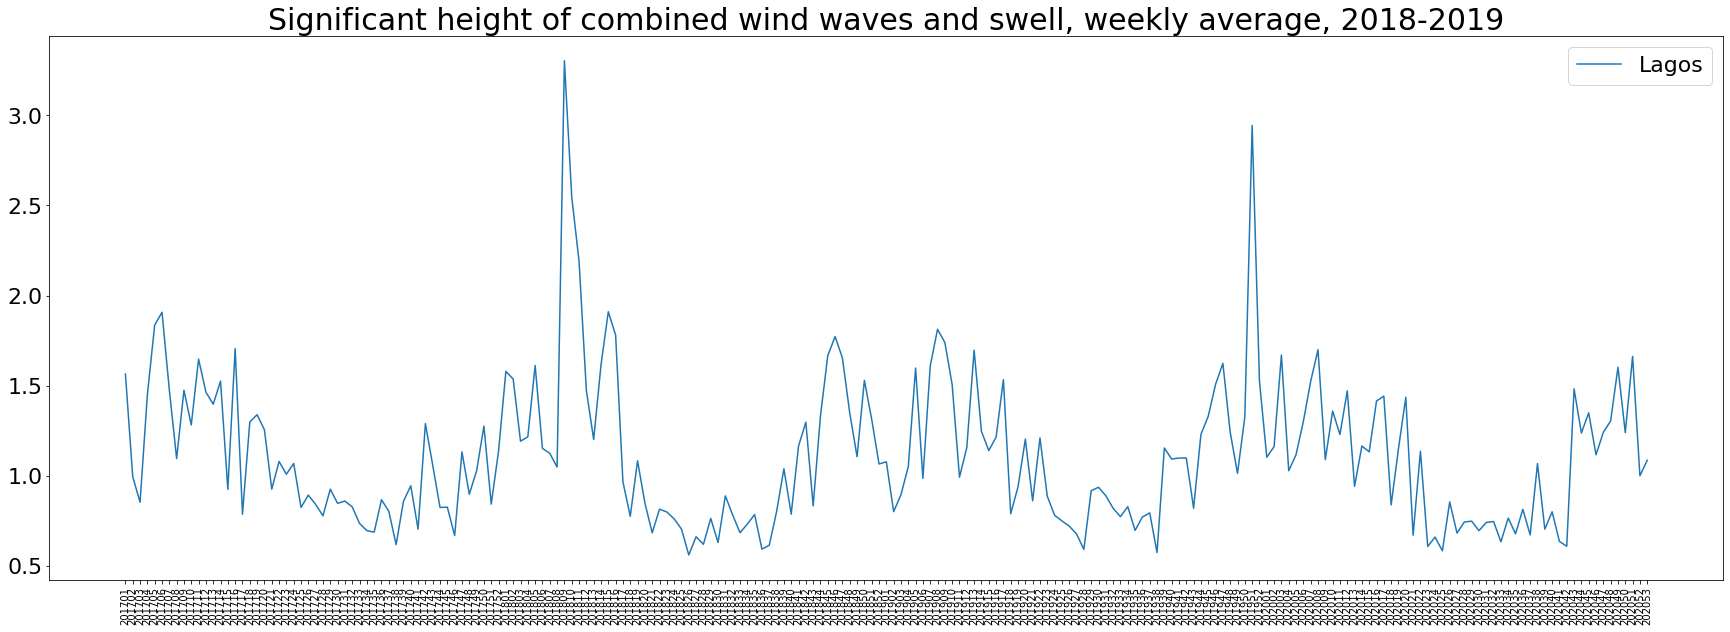

In [62]:
plot_weekly(['Lagos'], 'swh')